# Heat Event Identification

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kendalltau
import geopandas as gpd
import folium
import seaborn as sns
from scipy import stats
import sys
import os

# Update paths to get source code from notebook_utils
curr_dir = os.path.dirname(os.path.abspath('notebooks'))
proj_dir = os.path.dirname(curr_dir)
src_path = os.path.join(proj_dir, 'src')
sys.path.append(src_path)

from notebook_utils.preprocessing import *
from notebook_utils.heat_identification import *

# Create combined dataframe from ghcn_cleaned files
CA_stations_dfs = combine_files_to_dfs('../data/processed/ghcn_cleaned')

Processed file: CA_2003_clean.csv
Processed file: CA_2004_clean.csv
Processed file: CA_2005_clean.csv
Processed file: CA_2006_clean.csv
Processed file: CA_2007_clean.csv
Processed file: CA_2008_clean.csv
Processed file: CA_2009_clean.csv
Processed file: CA_2010_clean.csv
Processed file: CA_2011_clean.csv
Processed file: CA_2012_clean.csv
Processed file: CA_2013_clean.csv
Processed file: CA_2014_clean.csv
Processed file: CA_2015_clean.csv
Processed file: CA_2016_clean.csv
Processed file: CA_2017_clean.csv
Processed file: CA_2018_clean.csv
Processed file: CA_2019_clean.csv
Processed file: CA_2020_clean.csv
Processed file: CA_2021_clean.csv
Processed file: CA_2022_clean.csv
Processed file: CA_2023_clean.csv


# Heat Event Definition

1. CTX95pct. The threshold is the calendar day 95th percentile of Tmax based on a 15-day window centered on a given day; that is, there is a different percentile threshold for each day of the year to account for the seasonal cycle.

Source for heat event and heat metric definitions: Hulley, G.C., Dousset, B. and Kahn, B.H., 2020. Rising trends in heatwave metrics across southern California. Earth's Future, 8(7), p.e2020EF001480.

### Extract Daily Maximum and Minimum

In [2]:
CA_stations_dfs['datetime'] = pd.to_datetime(CA_stations_dfs['datetime'])
CA_stations_dfs['Date'] = CA_stations_dfs['datetime'].dt.date

# Calculate daily maximum and minimum temperatures
daily_temp = CA_stations_dfs.groupby(['Station_name', 'Latitude', 'Longitude', 'Date']).agg( Tmax =('Temperature', 'max')).reset_index()

# Identify Heat Events

### Calculate 95th percentile for Tmax and Tmin Based on 15-Day Window

In [3]:
# Calculate 95th percentile of daily maximum and minimum temperatures
daily_temp['CTX95pct'] = daily_temp.groupby('Station_name')['Tmax'].apply(calc_rolling_percentile).reset_index(drop=True)

### Find Heat Events

In [4]:
# Identify heat events based on 95th percentile of daily maximum and minimum temperatures
daily_temp['heat_event'] = daily_temp['Tmax'] > daily_temp['CTX95pct']

In [5]:
daily_temp.head()

,Station_name,Latitude,Longitude,Date,Tmax,CTX95pct,heat_event
0,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-01,13.4,NaN,False
1,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-02,13.7,NaN,False
2,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-03,15.3,NaN,False
3,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-04,15.8,NaN,False
4,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-05,13.7,NaN,False


# Heat Event Metrics

* Frequency: number of heatwaves per year within detection window.
* Duration: total number of contiguous days from start to end of heatwave event.
* Intensity: maximum temperature during a heatwave event minus the 95th percentile climatology of temperatures for a 15-day window centered on the heatwave event.
(Hulley, 2020)

### Identify Heat Event Groups

In [6]:
heat_groups_df = identify_heat_groups(daily_temp)
heat_groups_df

,Station_name,Latitude,Longitude,Date,Tmax,CTX95pct,heat_event,heat_event_group
0,ALTURAS MUNI AP,41.4836,-120.5614,2003-02-21,16.3,15.60,True,1
1,ALTURAS MUNI AP,41.4836,-120.5614,2003-02-22,17.2,16.57,True,1
2,ALTURAS MUNI AP,41.4836,-120.5614,2003-03-25,18.7,18.21,True,2
3,ALTURAS MUNI AP,41.4836,-120.5614,2003-03-26,18.9,18.76,True,2
4,ALTURAS MUNI AP,41.4836,-120.5614,2003-05-10,18.0,17.37,True,3
...,...,...,...,...,...,...,...,...
30025,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-08,18.0,17.58,True,12476
30026,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-09,21.6,19.08,True,12476
30027,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-10,22.2,21.78,True,12476
30028,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-26,24.7,24.56,True,12477


### Calculate Heat Event Metrics

In [7]:
heat_event_metrics = calc_heat_event_metrics(heat_groups_df)
heat_event_metrics

,Station_name,Latitude,Longitude,Year,heat_event_group,Start_date,End_date,Duration,Intensity,Frequency
0,ALTURAS MUNI AP,41.4836,-120.5614,2003,1,2003-02-21,2003-02-22,2,0.63,7
1,ALTURAS MUNI AP,41.4836,-120.5614,2003,2,2003-03-25,2003-03-26,2,0.14,7
2,ALTURAS MUNI AP,41.4836,-120.5614,2003,3,2003-05-10,2003-05-13,4,0.42,7
3,ALTURAS MUNI AP,41.4836,-120.5614,2003,4,2003-05-21,2003-05-23,3,1.40,7
4,ALTURAS MUNI AP,41.4836,-120.5614,2003,5,2003-07-17,2003-07-19,3,0.70,7
...,...,...,...,...,...,...,...,...,...,...
12485,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2022,12473,2022-11-15,2022-11-16,2,1.05,14
12486,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2022,12474,2022-12-23,2022-12-25,3,0.42,14
12487,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023,12475,2023-03-11,2023-03-13,3,1.12,3
12488,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023,12476,2023-04-08,2023-04-10,3,0.42,3


In [8]:
heat_event_metrics['Frequency'].describe()

count    12490.000000
mean         8.631545
std          2.645893
min          1.000000
25%          7.000000
50%          8.000000
75%         10.000000
max         17.000000
Name: Frequency, dtype: float64

# Spatiotemporal Patterns of Heat Events

## Spatial Analysis

#### Create Geodataframe

In [9]:
heat_event_gdf = gpd.GeoDataFrame(heat_event_metrics, geometry=gpd.points_from_xy(heat_event_metrics.Longitude, heat_event_metrics.Latitude))
heat_event_gdf.crs = 'EPSG:4326'

#### Interactive map of occurence and intensity of heat events across California

In [10]:
create_heat_event_map(heat_event_gdf)

## Temporal Trends

### Calculate Annual Metrics

In [16]:
# Calculate annual frequency and average intensity by year and by station
annual_station_metrics = heat_event_gdf.groupby(['Station_name', 'Year', 'Frequency']).agg({'Intensity': 'mean'}).reset_index()

# Calculate yearly metrics for all stations
annual_metrics = annual_station_metrics.groupby('Year').agg({'Frequency': 'mean', 'Intensity': 'mean'}).reset_index()

### Visualize Trends

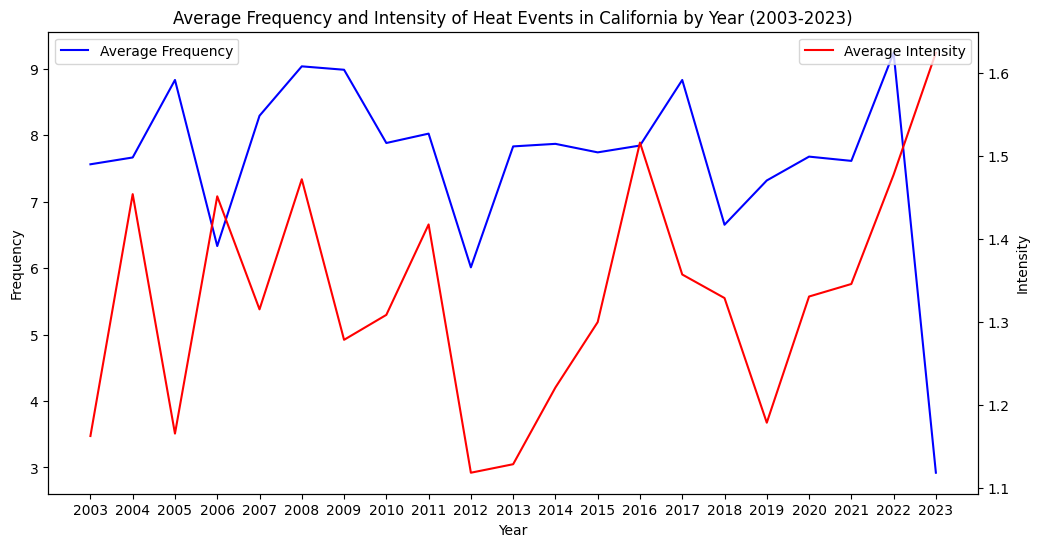

In [17]:
# Plot frequency and intensity of heat events for individual stations and for California
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=annual_metrics, x='Year', y='Frequency', ax=ax1, label='Average Frequency', color='blue')
ax2 = ax1.twinx()
sns.lineplot(data=annual_metrics, x='Year', y='Intensity', ax=ax2, label='Average Intensity', color='red')

ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Intensity')
ax1.set_title('Average Frequency and Intensity of Heat Events in California by Year (2003-2023)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


### Statistical Analysis of Trends